## Stroke prediction
### Датасет используется для прогнозирования вероятности инсульта у пациента на основе входных параметров.
### Описание признаков
- **id**: unique identifier
- **gender**: "Male", "Female" or "Other"
- **age**: age of the patient
- **hypertension**: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- **heart_disease**: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- **ever_married**: "No" or "Yes"
- **work_type**: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- **Residence_type**: "Rural" or "Urban"
- **avg_glucose_level**: average glucose level in blood
- **bmi**: body mass index
- **smoking_status**: "formerly smoked", "never smoked", "smokes" or "Unknown"*
- **stroke**: 1 if the patient had a stroke or 0 if not.

Note: "Unknown" in smoking_status means that the information is unavailable for this patient

[Ссылка](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) на датасет и его описание.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Загрузка данных
df_orig = pd.read_csv('data/healthcare-dataset-stroke-data.csv', index_col='id')
# Разделим датафрейм на y и X
y = df_orig['stroke'].copy()
X_orig = df_orig.drop(columns=['stroke'], inplace=False)
num_feat = len(X_orig.columns) 
num_obj = len(X_orig)
print(f'Количество признаков: {num_feat}')
print(f'Количество объектов: {num_obj}')
X_orig.head()

Количество признаков: 10
Количество объектов: 5110


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked


In [2]:
y.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

# Визуализация данных
Всегда полезно перед тем как строить модели, попробовать визуализировать данные. Зачастую это помогает улучшить качество данных и как следствие качесвто модели.

Text(0.5, 1.0, 'Pie chart of the "stroke" column\n     "1" $-$ patient had a stroke,\n     "0" $-$ patient did not have a stroke')

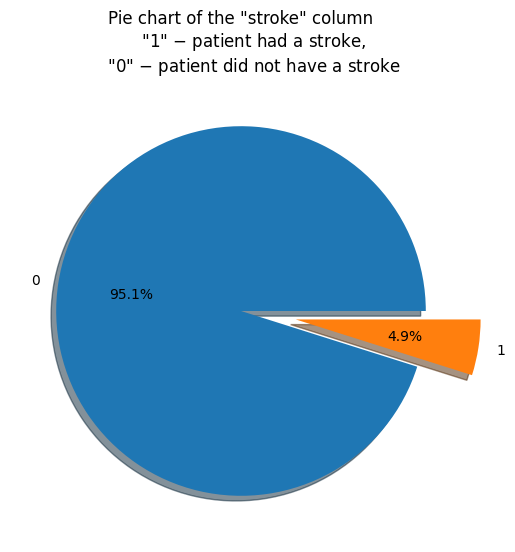

In [3]:
# Круговая диаграмма
plt.figure(figsize=(10, 6))
plt.pie(y.value_counts(), labels=['0', '1'], autopct='%.1f%%', shadow=True, explode=(0, 0.3));  
plt.title('Pie chart of the "stroke" column\n \
    "1" $-$ patient had a stroke,\n \
    "0" $-$ patient did not have a stroke')

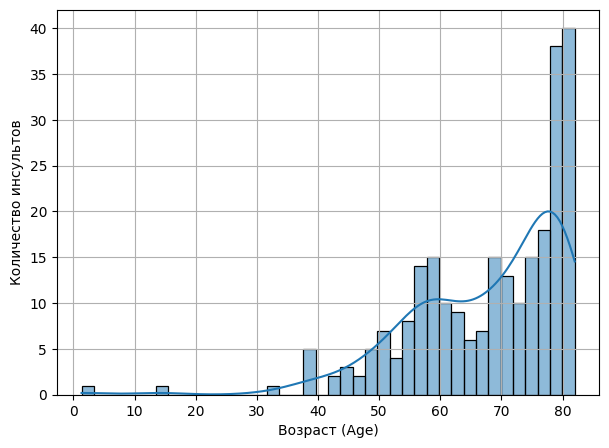

In [4]:
# Зависимость Stroke от age
plt.figure(figsize=(7, 5))
age_stroke = X_orig['age'].loc[y==1]
sns.histplot(x=age_stroke, bins=40, kde=True)
plt.xlabel('Возраст (Age)')
plt.ylabel('Количество инсультов')
plt.grid()

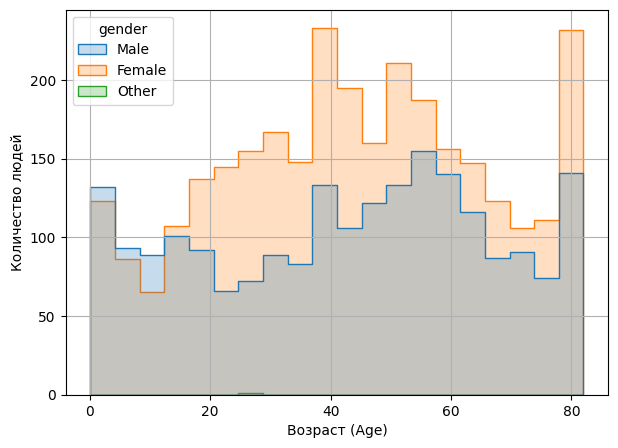

In [5]:
# Распределение возрастов
plt.figure(figsize=(7, 5))
sns.histplot(x=X_orig['age'], hue=X_orig['gender'], element='step', legend=True)
plt.xlabel('Возраст (Age)')
plt.ylabel('Количество людей')
plt.grid()

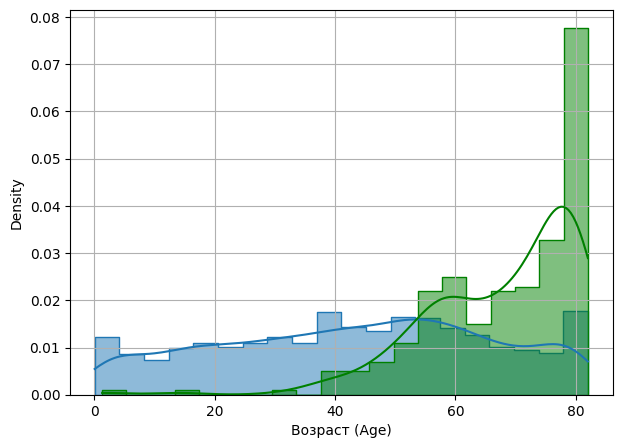

In [6]:
# Возраст людей, у которых был инсульт
age_stroke = X_orig['age'].loc[y==1]
fig, ax = plt.subplots(figsize=(7, 5))
# Распределение возрастов всех пациентов
sns.histplot(x=X_orig['age'], ax=ax, stat='density', kde=True, element='step')
# Только у которых y == 1
sns.histplot(x=age_stroke, ax=ax, bins=20, stat='density', kde=True, element='step', color='g')
ax.set_xlabel('Возраст (Age)')
ax.grid()

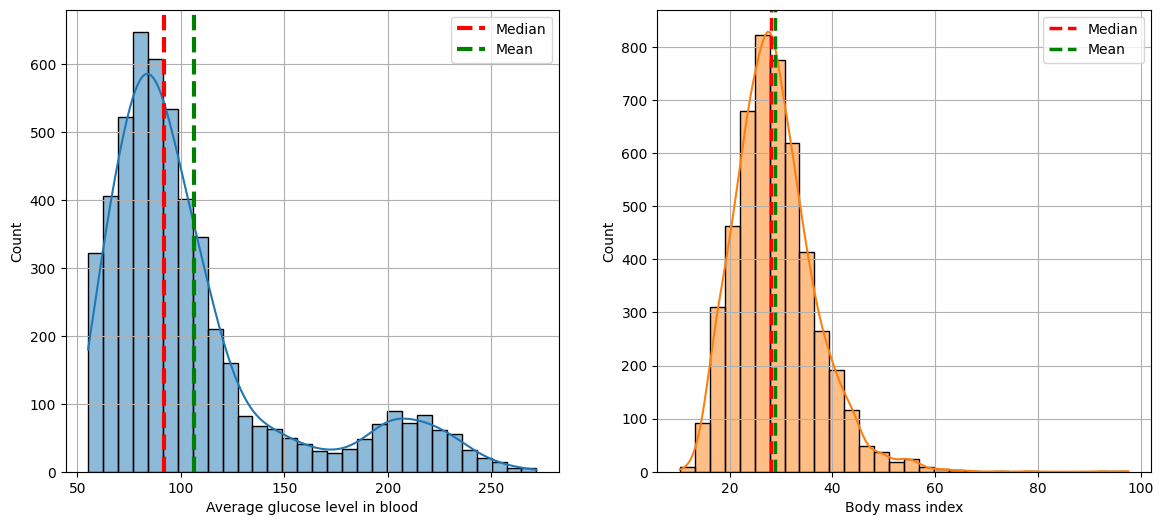

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# Глюкоза
sns.histplot(X_orig['avg_glucose_level'], ax=ax[0], bins=30, kde=True)
ax[0].set_xlabel('Average glucose level in blood')
ax[0].axvline(X_orig['avg_glucose_level'].median(), label='Median', linestyle='--', color='r', lw=3)
ax[0].axvline(X_orig['avg_glucose_level'].mean(), label='Mean', linestyle='--', color='g', lw=3)
ax[0].legend()
ax[0].grid()
# BMI (индекс массы тела)
sns.histplot(x=X_orig['bmi'], ax=ax[1], bins=30, kde=True, color='tab:orange')
ax[1].set_xlabel('Body mass index')
ax[1].axvline(X_orig['bmi'].median(), label='Median', linestyle='--', color='r', lw=2.5)
ax[1].axvline(X_orig['bmi'].mean(), label='Mean', linestyle='--', color='g', lw=2.5)
ax[1].legend()
ax[1].grid()


Text(0, 0.5, 'Smoking status')

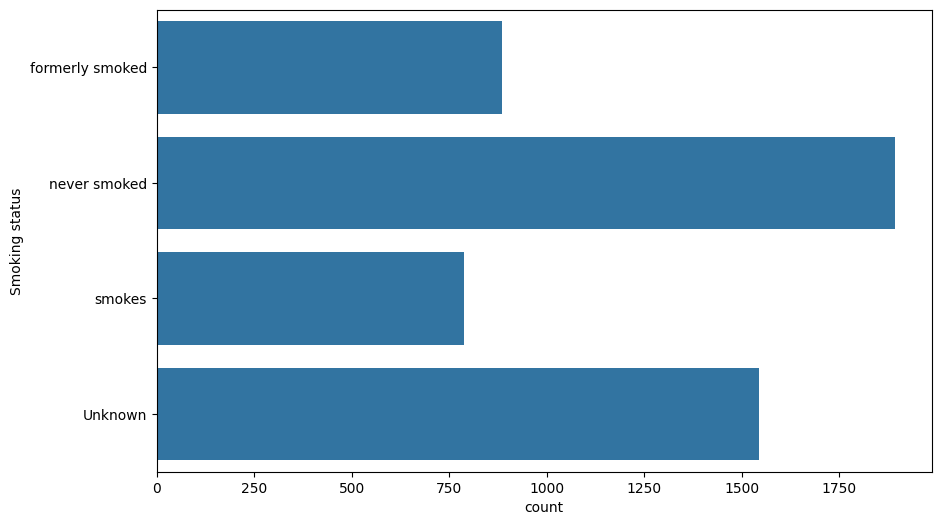

In [8]:
# Smoking status
plt.figure(figsize=(10, 6))
sns.countplot(y=X_orig['smoking_status'])
plt.ylabel('Smoking status')

Text(0.5, 1.0, '"1" $-$ patient has hypertension,\n     "0" $-$ patient does not have hypertension')

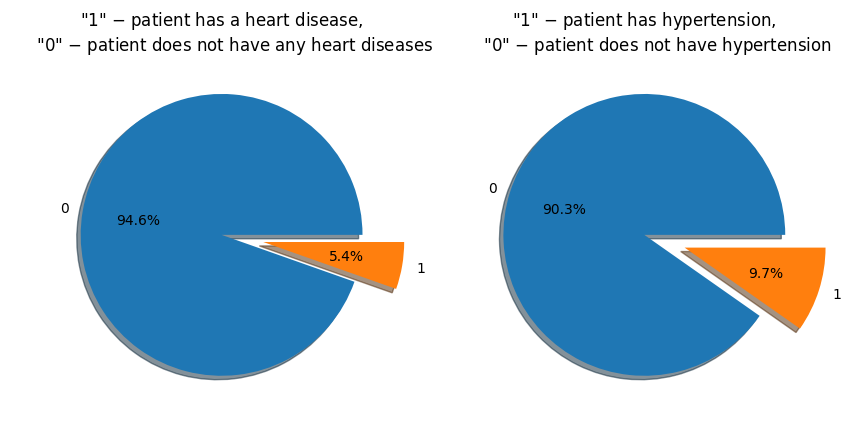

In [9]:
# Круговые диаграммы с информацией о процентах людей с сердечными заболеваниями и гипертонией
fig, ax  = plt.subplots(1, 2, figsize=(10, 6))
ax[0].pie(X_orig['heart_disease'].value_counts(), labels=['0', '1'], autopct='%.1f%%', shadow=True, explode=(0, 0.3));  
ax[0].set_title('"1" $-$ patient has a heart disease,\n \
    "0" $-$ patient does not have any heart diseases')
ax[1].pie(X_orig['hypertension'].value_counts(), labels=['0', '1'], autopct='%.1f%%', shadow=True, explode=(0, 0.3));  
ax[1].set_title('"1" $-$ patient has hypertension,\n \
    "0" $-$ patient does not have hypertension')


Text(0.5, 0.98, 'People with Stroke == 1')

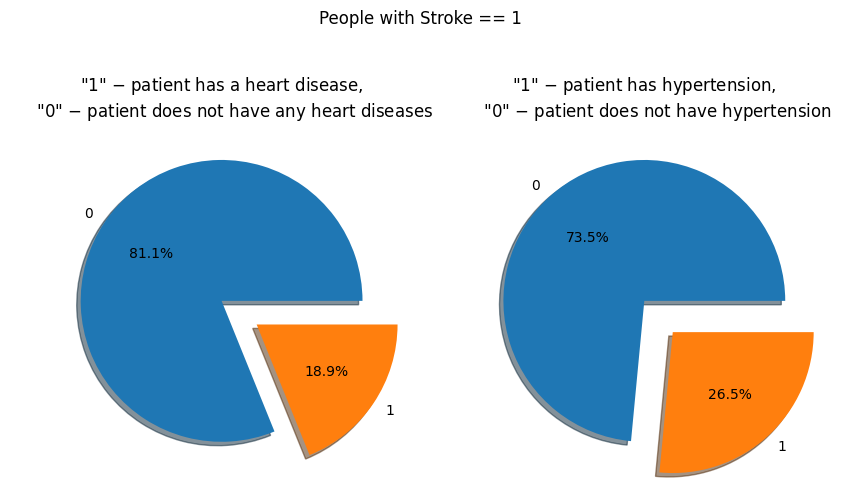

In [10]:
# Можно посмотреть те же диаграммы, но только среди людей со stroke == 1
fig, ax  = plt.subplots(1, 2, figsize=(10, 6))
ax[0].pie(X_orig['heart_disease'].loc[y==1].value_counts(), labels=['0', '1'], autopct='%.1f%%', shadow=True, explode=(0, 0.3));  
ax[0].set_title('"1" $-$ patient has a heart disease,\n \
    "0" $-$ patient does not have any heart diseases')
ax[1].pie(X_orig['hypertension'].loc[y==1].value_counts(), labels=['0', '1'], autopct='%.1f%%', shadow=True, explode=(0, 0.3));  
ax[1].set_title('"1" $-$ patient has hypertension,\n \
    "0" $-$ patient does not have hypertension')
fig.suptitle('People with Stroke == 1')

## Преобразование данных
Некоторые категориальные признаки могут принимать одно из двух значений. Заменим их на 0 и 1.

In [11]:
X_orig.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked


In [12]:
X_prep = X_orig.copy()
# Закодируем катогориальные признаки
# Male - 1, Female - 0
X_prep['gender'] = X_prep['gender'].map({'Male': 1, 'Female': 0, 'Other': 1})
# urban - 1, rural - 0
X_prep['Residence_type'] = X_prep['Residence_type'].map({'Urban': 1, 'Rural': 0})
# ever_married yes - 1, no - 0
X_prep['ever_married'] = X_prep['ever_married'].map({'Yes': 1, 'No': 0})

X_prep.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
9046,1,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked
51676,0,61.0,0,0,1,Self-employed,0,202.21,NaN,never smoked
31112,1,80.0,0,1,1,Private,0,105.92,32.5,never smoked
60182,0,49.0,0,0,1,Private,1,171.23,34.4,smokes
1665,0,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked


Если категориальный признак - бинарный (принимает одно значение из двух), то мы можем закодировать такое признак с помощью "1" и "0". Но что делать, если признак может принимать 3 и более значений? Самый простой способ – использовать **one-hot кодирование** (one-hot encoding). Пусть исходный признак мог принимать $M$ значений $c_1, \dots,c_M$. Заменим **один** категориальный признак на **$M$ признаков**, которые принимают значения 0 и 1. $i$-й признак будет отвечать на вопрос «принимает ли признак значение $c_i$?». Иными словами, вместо ячейки со значением $c_i$ у объекта появляется строка нулей и единиц, в которой единица стоит только на $i$-м месте.

In [13]:
X_prep = pd.get_dummies(X_prep, columns = ['work_type', 'smoking_status'], dtype=float)

X_prep.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,,
9046,1,67.0,0,1,1,1,228.69,36.6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
51676,0,61.0,0,0,1,0,202.21,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
31112,1,80.0,0,1,1,0,105.92,32.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
60182,0,49.0,0,0,1,1,171.23,34.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1665,0,79.0,1,0,1,0,174.12,24.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Как видим, несмотря на простоту данного метода, мы получили много новых признаков, которые при этом в основном состоят из нулей. Таким образом мы увеличили размерность наших данных. Проблема в том, что обучать алгоритмы становится гораздо тяжелее из-за так называемого **"проклятия размерности"**. Это явление заключается в том, что экспоненциально растет количество необходимых данных для решения задачи, поскольку число возможных конфигураций множества переменных также растет (когда мы увеличиваем количество признаков). 

In [14]:
X_prep['bmi'].isna().sum()

np.int64(201)

In [15]:
# Избавимся от NaN в BMI колонке
# Один из простейших способой - заменить медианным значением
X_prep['bmi'].fillna(X_prep['bmi'].median(), inplace=True)
X_prep.head()

C:\Users\Kirill\AppData\Local\Temp\ipykernel_28712\2867239746.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_prep['bmi'].fillna(X_prep['bmi'].median(), inplace=True)


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,,
9046,1,67.0,0,1,1,1,228.69,36.6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
51676,0,61.0,0,0,1,0,202.21,28.1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
31112,1,80.0,0,1,1,0,105.92,32.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
60182,0,49.0,0,0,1,1,171.23,34.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1665,0,79.0,1,0,1,0,174.12,24.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


В задачах машинного обучения данные часто масштабируются на этапе предобработки данных. Некоторые переменные могут иметь разный масштаб (цена квартиры, возраст и т.д.) и использование их в алгоритмах без какого-либо изменения может привести к искажению результатов работы модели. Есть несколько вариантов, как масштабировать данные:
- Стандартизация 
$$\tilde{x}_i=\frac{x_i-\mu}{\sigma}$$
Реализация в sklearn: sklearn.preprocessing.StandardScaler
- Приведение к отрезку $[0, 1]$
$$\tilde{x}_i=\frac{x_i-x_{i, min}}{x_{i, max}-x_{i, min}}$$
Реализация в sklearn: sklearn.preprocessing.MinMaxScaler

In [16]:
scaler = StandardScaler()
X_prep = pd.DataFrame(data=scaler.fit_transform(X_prep), index=X_prep.index, columns=X_prep.columns)
X_prep.head()


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,,
9046,1.189510,1.051434,-0.328602,4.185032,0.723884,0.984080,2.706375,1.005086,-0.384111,-0.065756,0.864297,-0.436881,-0.394112,-0.658011,2.184951,-0.766774,-0.427313
51676,-0.840682,0.786070,-0.328602,-0.238947,0.723884,-1.016178,2.121559,-0.098981,-0.384111,-0.065756,-1.157010,2.288955,-0.394112,-0.658011,-0.457676,1.304165,-0.427313
31112,1.189510,1.626390,-0.328602,4.185032,0.723884,-1.016178,-0.005028,0.472536,-0.384111,-0.065756,0.864297,-0.436881,-0.394112,-0.658011,-0.457676,1.304165,-0.427313
60182,-0.840682,0.255342,-0.328602,-0.238947,0.723884,0.984080,1.437358,0.719327,-0.384111,-0.065756,0.864297,-0.436881,-0.394112,-0.658011,-0.457676,-0.766774,2.340204
1665,-0.840682,1.582163,3.043196,-0.238947,0.723884,-1.016178,1.501184,-0.631531,-0.384111,-0.065756,-1.157010,2.288955,-0.394112,-0.658011,-0.457676,1.304165,-0.427313


<Axes: >

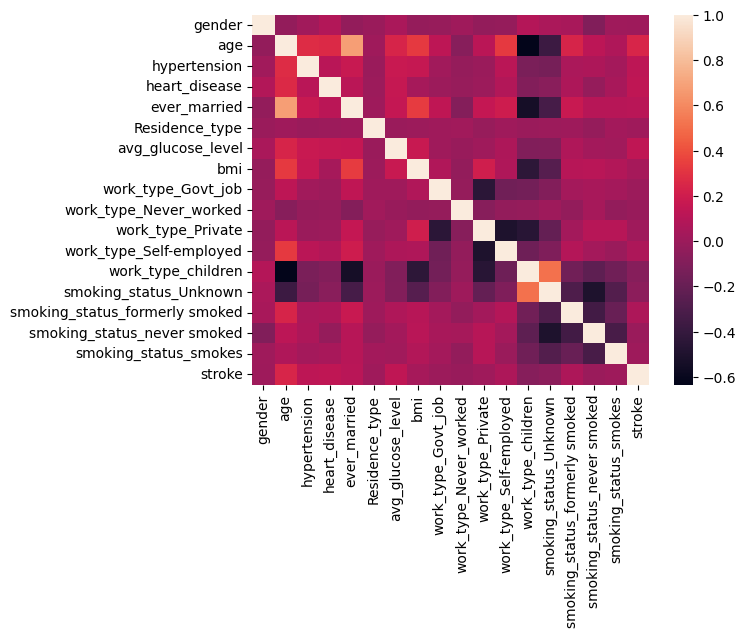

In [17]:
sns.heatmap(X_prep.merge(y,left_index=True, right_index=True).corr())

### Кросс-валидация
Кросс-валидация — это метод, предназначенный для оценки качества работы модели, широко применяемый в машинном обучении. Он помогает сравнить между собой различные модели и выбрать наилучшую для конкретной задачи. Существуют различные техники и приемы кросс-валидации, о некоторых из них мы и поговорим.

- **Hold-out cross-validation** (или просто hold-out), **Валидация на отложенных данных**

Представляет собой разбиение на train и test
<center><img src="data/hold-out.png" alt="drawing" width="800"/></center>

В библиотеке scikit-learn такое разбиение можно реализовать следующим образом:

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
 
X_exmpl, y_exmpl = np.arange(1000).reshape((500, 2)), np.arange(500)
X_train, X_test, y_train, y_test = train_test_split(
    X_exmpl, y_exmpl, 
    test_size=0.2, 
    random_state=42
) 

В sklearn по умолчанию выставлен параметр ``shuffle=True``, то есть перед разделением на тренировочное и тестовое множества происходит перемешивание семплов (и для воспроизводимости такого разбиения нужно фиксировать ``random_state``).

Если данных достаточно много, то можно также предусмотреть и валидационное множество

In [19]:
X_exmpl, y_exmpl = np.arange(1000).reshape((500, 2)), np.arange(500)
X_train, X_test, y_train, y_test = train_test_split(
    X_exmpl, y_exmpl, 
    test_size=0.2, 
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.1, 
    random_state=42
)

- **k-Fold**
Данный метод является обобщением метода hold-out. Алгоритм выглядит следующим образом:
1. Выбирается число $k$ (обычно 5-10).
2. Датасет разбивается на $k$ частей, которые называются *фолдами*.
3. Запускается цикл из $k$ итераций, на каждом из которых один фолд выступает в роли *тестового множества*, а объединение остальных — в роли *тренировочного*. То есть обучение модели происходит на $k-1$ фолде, а тест на оставшемся.
4. Как правило финальное качество модели получается путем усреднения $k$ получившихся результатов.
<center><img src="data//k-fold.jpg" alt="drawing" width="1000"/></center>

Реализация в sklearn:

In [20]:
import numpy as np
from sklearn.model_selection import KFold
 
X_exmpl = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14, 15], [16, 17, 18]])
y_exmpl = np.array([1, 2, 3, 4, 5, 6])
kf = KFold(n_splits=3, shuffle=True)
 
for train_index, test_index in kf.split(X_exmpl):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_exmpl[train_index], X_exmpl[test_index]
    y_train, y_test = y_exmpl[train_index], y_exmpl[test_index]

TRAIN: [0 1 2 3] TEST: [4 5]
TRAIN: [1 3 4 5] TEST: [0 2]
TRAIN: [0 2 4 5] TEST: [1 3]


Метод k-Fold даёт более надёжную оценку качества модели, чем hold-out, так как обучение и тест модели происходят на разных подмножествах исходного датасета. Однако проведение k итераций обучения и теста может быть вычислительно затратным, и поэтому метод обычно применяют либо когда данных достаточно мало, либо при наличии большого количества вычислительных ресурсов. В реальных задачах как правило данных достаточно много, чтобы hold-out давал хорошую оценку, поэтому его используют чаще.

# Logistic regression

In [21]:
# Cross-validator
cv = KFold(n_splits=5, shuffle=True, random_state=42)
C_regul = [1e-3, 1e-2, 1e-1, 1.0]
for regul in C_regul:
    clf = LogisticRegression(penalty='l2', C=regul).fit(X_prep, y)
    print('Cross-validation mean score: %f' % 
          cross_val_score(clf, X_prep, y, cv=cv, scoring='roc_auc').mean())
    # print(cross_val_score(clf, X_prep, y, cv=cv, scoring='roc_auc'))

Cross-validation mean score: 0.812536
Cross-validation mean score: 0.833942
Cross-validation mean score: 0.841826
Cross-validation mean score: 0.841863
